In [1]:
%load_ext autoreload

import numpy
import micrograd.visualization as viz

In [63]:
import numpy as np


class Value:
    """
    when op is called: create a new node holding children nodes; initiate its grad function that
    that can set children's grad value.

    when backward is called: set the grad for children nodes: children_grad = own_grad * out2in_grad
    """
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self.label = label
        self.grad_fn = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, label={self.label})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def grad():
            self.grad += out.grad
            other.grad += out.grad
        out.grad_fn = grad
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        return self + (-other)
    
    def __rsub__(self, other):
        return -self + other
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def grad():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out.grad_fn = grad
        return out
    
    def __rmul__(self, other):
        return self * other

    def __pow__(self, k):
        if not isinstance(k, (float, int)):
            raise ValueError("exponent has to be float or integer")

        out = Value(self.data ** k, set([self]), "**")
        def grad():
            self.grad += k * self.data ** (k - 1)
        out.grad_fn = grad
        return out

    def __truediv__(self, other):
        return self * other ** -1
    
    def __rtruediv__(self, other):
        return other * self ** -1

    def relu(self):
        out = Value(max(0, self.data), set([self]), "relu")
        def grad():
            if self.data >=0:
                self.grad += out.grad
            else:
                self.grad = 0
        out.grad_fn = grad
        return out

    def sigmoid(self):
        sigma = 1 / (1 + np.exp(-self.data))
        out = Value(sigma, (self,), "sigmoid")
        def grad():
            self.grad += sigma * (1 - sigma) * out.grad
        out.grad_fn = grad
        return out

    def backward(self):
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for n in v._prev:
                    build_topo(n)
                topo.append(v)
        build_topo(self)
        for v in topo[::-1]:
            v.grad_fn()

In [64]:
x1 = Value(0.2, label="x1")
x2 = Value(0.3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(0.6, label="w2")
b = Value(0.7, label="b")

x1w1 = x1 * w1
x2w2 = x2 * w2
y1 = x1w1 + x2w2
y2 = y1 + b
y3 = y2.sigmoid()

In [65]:
y3.grad = 1.0
y3.backward()

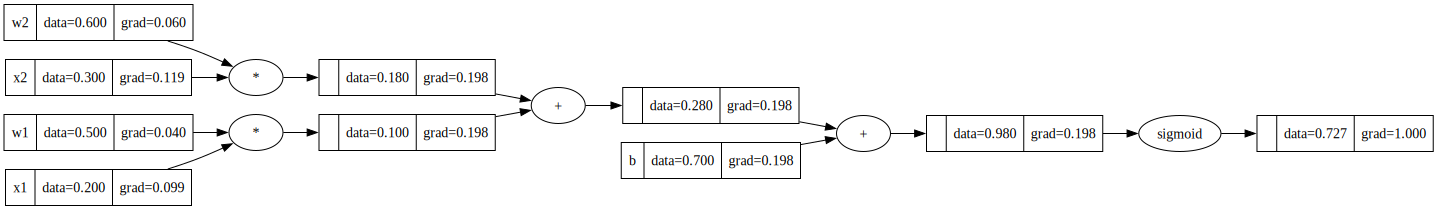

In [66]:
viz.draw_dot(y3)

In [59]:
import torch

x1 = torch.tensor([0.2]).double(); x1.requires_grad = True
x2 = torch.tensor([0.3]).double(); x2.requires_grad = True
w1 = torch.tensor([0.5]).double(); w1.requires_grad = True
w2 = torch.tensor([0.6]).double(); w2.requires_grad = True
b = torch.tensor([0.7]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
y = torch.sigmoid(n)

In [60]:
y.backward()

In [61]:
w1.grad, w2.grad, x1.grad, x2.grad, b.grad

(tensor([0.0397], dtype=torch.float64),
 tensor([0.0595], dtype=torch.float64),
 tensor([0.0992], dtype=torch.float64),
 tensor([0.1191], dtype=torch.float64),
 tensor([0.1984], dtype=torch.float64))